In [78]:
# Initial imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pprint import pprint
import psycopg2
from psycopg2 import sql

#Spark imports
!wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j
import os
import sys


# Start a SparkSession
import findspark
findspark.init()


%matplotlib inline

In [79]:
# Import packages
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").config("spark.driver.memory", "2g").getOrCreate()

In [80]:
# Read in data from S3 Bucket
from pyspark import SparkFiles
url = "https://aws-project-4.s3.ca-central-1.amazonaws.com/heart_attack_prediction_dataset.csv"
spark.sparkContext.addFile(url)
dataset = spark.read.csv(SparkFiles.get("heart_attack_prediction_dataset.csv"), sep=",", header=True)
dataset.show(5)

24/02/08 23:01:48 WARN SparkContext: The path https://aws-project-4.s3.ca-central-1.amazonaws.com/heart_attack_prediction_dataset.csv has been added already. Overwriting of added paths is not supported in the current version.
+----------+---+------+-----------+--------------+----------+--------+--------------+-------+-------+-------------------+-----------------------+---------+-----------------------+--------------+------------+-----------------------+------+------------------+-------------+-------------------------------+-------------------+---------+-------------+-------------------+-----------------+
|Patient ID|Age|   Sex|Cholesterol|Blood Pressure|Heart Rate|Diabetes|Family History|Smoking|Obesity|Alcohol Consumption|Exercise Hours Per Week|     Diet|Previous Heart Problems|Medication Use|Stress Level|Sedentary Hours Per Day|Income|               BMI|Triglycerides|Physical Activity Days Per Week|Sleep Hours Per Day|  Country|    Continent|         Hemisphere|Heart Attack Risk|
+-

In [81]:
# Register the DataFrame as a temporary view
dataset.createOrReplaceTempView("heart_attack_prediction")

# Perform the transformation using Spark SQL
dataset_transformed = spark.sql("""
    SELECT *,
           CAST(SPLIT(`Blood Pressure`, '/')[0] AS INT) AS `Systolic Pressure`,
           CAST(SPLIT(`Blood Pressure`, '/')[1] AS INT) AS `Diastolic Pressure`
    FROM heart_attack_prediction
""")


In [82]:
# Drop the original "Blood Pressure" column
dataset_transformed = dataset_transformed.drop("Blood Pressure")

In [83]:
# Show the updated DataFrame schema
dataset_transformed.printSchema()

# Display the updated DataFrame
dataset_transformed.show(5)

root
 |-- Patient ID: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Cholesterol: string (nullable = true)
 |-- Heart Rate: string (nullable = true)
 |-- Diabetes: string (nullable = true)
 |-- Family History: string (nullable = true)
 |-- Smoking: string (nullable = true)
 |-- Obesity: string (nullable = true)
 |-- Alcohol Consumption: string (nullable = true)
 |-- Exercise Hours Per Week: string (nullable = true)
 |-- Diet: string (nullable = true)
 |-- Previous Heart Problems: string (nullable = true)
 |-- Medication Use: string (nullable = true)
 |-- Stress Level: string (nullable = true)
 |-- Sedentary Hours Per Day: string (nullable = true)
 |-- Income: string (nullable = true)
 |-- BMI: string (nullable = true)
 |-- Triglycerides: string (nullable = true)
 |-- Physical Activity Days Per Week: string (nullable = true)
 |-- Sleep Hours Per Day: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Continent: strin

In [84]:
from pyspark.sql.functions import when

# Update 'Sex' column
dataset_transformed = dataset_transformed.withColumn("Sex", when(dataset_transformed["Sex"] == "Female", 0).when(dataset_transformed["Sex"] == "Male", 1).otherwise(dataset_transformed["Sex"]))

# Update 'Hemisphere' column
dataset_transformed = dataset_transformed.withColumn("Hemisphere", when(dataset_transformed["Hemisphere"] == "Northern Hemisphere", 0).when(dataset_transformed["Hemisphere"] == "Southern Hemisphere", 1).otherwise(dataset_transformed["Hemisphere"]))

# Show the updated DataFrame
dataset_transformed.show(5)


+----------+---+---+-----------+----------+--------+--------------+-------+-------+-------------------+-----------------------+---------+-----------------------+--------------+------------+-----------------------+------+------------------+-------------+-------------------------------+-------------------+---------+-------------+----------+-----------------+-----------------+------------------+
|Patient ID|Age|Sex|Cholesterol|Heart Rate|Diabetes|Family History|Smoking|Obesity|Alcohol Consumption|Exercise Hours Per Week|     Diet|Previous Heart Problems|Medication Use|Stress Level|Sedentary Hours Per Day|Income|               BMI|Triglycerides|Physical Activity Days Per Week|Sleep Hours Per Day|  Country|    Continent|Hemisphere|Heart Attack Risk|Systolic Pressure|Diastolic Pressure|
+----------+---+---+-----------+----------+--------+--------------+-------+-------+-------------------+-----------------------+---------+-----------------------+--------------+------------+-------------------

In [85]:
dataset_transformed.describe().show()

+-------+----------+------------------+------------------+-----------------+-----------------+------------------+-------------------+------------------+------------------+-------------------+-----------------------+---------+-----------------------+-------------------+------------------+-----------------------+------------------+------------------+------------------+-------------------------------+-------------------+---------+-------------+-------------------+-------------------+------------------+------------------+
|summary|Patient ID|               Age|               Sex|      Cholesterol|       Heart Rate|          Diabetes|     Family History|           Smoking|           Obesity|Alcohol Consumption|Exercise Hours Per Week|     Diet|Previous Heart Problems|     Medication Use|      Stress Level|Sedentary Hours Per Day|            Income|               BMI|     Triglycerides|Physical Activity Days Per Week|Sleep Hours Per Day|  Country|    Continent|         Hemisphere|  Heart Att

In [86]:
import requests
url = "https://countriesnow.space/api/v0.1/countries/capital"
payload = {}
headers = {}

response = requests.request("GET", url, headers=headers, data=payload)

In [87]:
import csv
# Check if the API request was successful (status code 200)
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()

    # Extract relevant information (country name and capital) from the response
    country_data = [(country["name"], country["capital"]) for country in data.get("data", [])]

    # Define CSV file path
    csv_file_path = "country_capitals.csv"

    # Write the extracted data to a CSV file
    with open(csv_file_path, mode="w", newline="", encoding="utf-8") as csv_file:
        fieldnames = ["Country", "Capital"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

        # Write header
        writer.writeheader()

        # Write data rows
        for country, capital in country_data:
            writer.writerow({"Country": country, "Capital": capital})

    print(f"CSV file saved at: {csv_file_path}")

else:
    # Print an error message if the API request fails
    print(f"Error: {response.status_code} - {response.text}")

CSV file saved at: country_capitals.csv


In [88]:
# Load the CSV file into a Spark DataFrame
mapping_df = spark.read.csv("country_capitals.csv", header=True, inferSchema=True)

# Show the DataFrame
mapping_df.show()


+-------------------+----------------+
|            Country|         Capital|
+-------------------+----------------+
|        Afghanistan|           Kabul|
|      Aland Islands|       Mariehamn|
|            Albania|          Tirana|
|            Algeria|         Algiers|
|     American Samoa|       Pago Pago|
|            Andorra|Andorra la Vella|
|             Angola|          Luanda|
|           Anguilla|      The Valley|
|         Antarctica|            null|
|Antigua and Barbuda|      St. John's|
|          Argentina|    Buenos Aires|
|            Armenia|         Yerevan|
|              Aruba|      Oranjestad|
|          Australia|        Canberra|
|            Austria|          Vienna|
|         Azerbaijan|            Baku|
|            Bahamas|          Nassau|
|            Bahrain|          Manama|
|         Bangladesh|           Dhaka|
|           Barbados|      Bridgetown|
+-------------------+----------------+
only showing top 20 rows



In [89]:
# Perform the join operation on the 'Country' column
merged_df = mapping_df.join(dataset_transformed, on='Country')

# Show the resulting DataFrame
merged_df.show(5)

+---------+------------+----------+---+---+-----------+----------+--------+--------------+-------+-------+-------------------+-----------------------+---------+-----------------------+--------------+------------+-----------------------+------+------------------+-------------+-------------------------------+-------------------+-------------+----------+-----------------+-----------------+------------------+
|  Country|     Capital|Patient ID|Age|Sex|Cholesterol|Heart Rate|Diabetes|Family History|Smoking|Obesity|Alcohol Consumption|Exercise Hours Per Week|     Diet|Previous Heart Problems|Medication Use|Stress Level|Sedentary Hours Per Day|Income|               BMI|Triglycerides|Physical Activity Days Per Week|Sleep Hours Per Day|    Continent|Hemisphere|Heart Attack Risk|Systolic Pressure|Diastolic Pressure|
+---------+------------+----------+---+---+-----------+----------+--------+--------------+-------+-------+-------------------+-----------------------+---------+----------------------

In [90]:
import logging

# Configure logging
logging.basicConfig(level=logging.WARNING)

url = "https://countriesnow.space/api/v0.1/countries/positions"
headers = {}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    data = response.json().get('data', [])

    # Specify the CSV file path
    csv_file_path = 'countries_data.csv'

    # Write the data to a CSV file
    with open(csv_file_path, 'w', newline='', encoding='utf-8') as csv_file:
        fieldnames = ['name', 'lat', 'long']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

        # Write the header
        writer.writeheader()

        # Write the data rows
        for entry in data:
            country = entry.get('name')
            latitude = entry.get('lat')
            longitude = entry.get('long')

            # Check if all required keys are present
            if country is not None and latitude is not None and longitude is not None:
                writer.writerow({'name': country, 'lat': latitude, 'long': longitude})
            else:
                logging.warning(f'Skipping entry without complete data: {entry}')

    print(f'Data has been written to {csv_file_path}')
else:
    print(f'Error: {response.status_code} - {response.text}')

Data has been written to countries_data.csv


In [91]:
# Read the CSV file into a Spark DataFrame
coordinates_df = spark.read.csv("countries_data.csv", header=True, inferSchema=True)

# Rename the 'name' column to 'Country'
coordinates_df = coordinates_df.withColumnRenamed("name", "Country")

# Show the DataFrame
coordinates_df.show()


+-------------------+--------+--------+
|            Country|     lat|    long|
+-------------------+--------+--------+
|        Afghanistan|    33.0|    65.0|
|            Albania|    41.0|    20.0|
|            Algeria|    28.0|     3.0|
|      AmericanSamoa|-14.3333|  -170.0|
|            Andorra|    42.5|     1.6|
|             Angola|   -12.5|    18.5|
|           Anguilla|   18.25|-63.1667|
|         Antarctica|   -90.0|     0.0|
|Antigua and Barbuda|   17.05|   -61.8|
|          Argentina|   -34.0|   -64.0|
|            Armenia|    40.0|    45.0|
|              Aruba|    12.5|-69.9667|
|          Australia|   -27.0|   133.0|
|            Austria| 47.3333| 13.3333|
|         Azerbaijan|    40.5|    47.5|
|            Bahamas|   24.25|   -76.0|
|            Bahrain|    26.0|   50.55|
|         Bangladesh|    24.0|    90.0|
|           Barbados| 13.1667|-59.5333|
|            Belarus|    53.0|    28.0|
+-------------------+--------+--------+
only showing top 20 rows



In [92]:
# Perform the join operation using Spark SQL and select desired columns
coordinates_df.createOrReplaceTempView("coordinates_df")
merged_df.createOrReplaceTempView("merged_df")
joined_df = spark.sql("""
    SELECT merged_df.*, coordinates_df.lat, coordinates_df.long
    FROM merged_df
    JOIN coordinates_df
    ON merged_df.Country = coordinates_df.Country
""")

# Show the resulting DataFrame
joined_df.show(5)


+---------+------------+----------+---+---+-----------+----------+--------+--------------+-------+-------+-------------------+-----------------------+---------+-----------------------+--------------+------------+-----------------------+------+------------------+-------------+-------------------------------+-------------------+-------------+----------+-----------------+-----------------+------------------+-----+-----+
|  Country|     Capital|Patient ID|Age|Sex|Cholesterol|Heart Rate|Diabetes|Family History|Smoking|Obesity|Alcohol Consumption|Exercise Hours Per Week|     Diet|Previous Heart Problems|Medication Use|Stress Level|Sedentary Hours Per Day|Income|               BMI|Triglycerides|Physical Activity Days Per Week|Sleep Hours Per Day|    Continent|Hemisphere|Heart Attack Risk|Systolic Pressure|Diastolic Pressure|  lat| long|
+---------+------------+----------+---+---+-----------+----------+--------+--------------+-------+-------+-------------------+-----------------------+--------

In [93]:
joined_df.describe().show()

+-------+---------+----------+----------+------------------+------------------+-----------------+-----------------+------------------+-------------------+------------------+------------------+-------------------+-----------------------+---------+-----------------------+-------------------+------------------+-----------------------+------------------+------------------+------------------+-------------------------------+-------------------+-------------+-------------------+-------------------+------------------+------------------+-----------------+------------------+
|summary|  Country|   Capital|Patient ID|               Age|               Sex|      Cholesterol|       Heart Rate|          Diabetes|     Family History|           Smoking|           Obesity|Alcohol Consumption|Exercise Hours Per Week|     Diet|Previous Heart Problems|     Medication Use|      Stress Level|Sedentary Hours Per Day|            Income|               BMI|     Triglycerides|Physical Activity Days Per Week|Sleep 

In [94]:
joined_df = joined_df.toPandas()
joined_df[:5]

,Country,Capital,Patient ID,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Continent,Hemisphere,Heart Attack Risk,Systolic Pressure,Diastolic Pressure,lat,long
0,Argentina,Buenos Aires,BMW7812,67,1,208,72,0,0,1,...,286,0,6,South America,1,0,158,88,-34.0,-64.0
1,Canada,Ottawa,CZE1114,21,1,389,98,1,1,1,...,235,1,7,North America,0,0,165,93,60.0,-95.0
2,France,Paris,BNI9906,21,0,324,72,1,0,0,...,587,4,4,Europe,0,0,174,99,46.0,2.0
3,Canada,Ottawa,JLN3497,84,1,383,73,1,1,1,...,378,3,4,North America,0,0,163,100,60.0,-95.0
4,Thailand,Bangkok,GFO8847,66,1,318,93,1,1,1,...,231,1,5,Asia,0,0,91,88,15.0,100.0


In [95]:
joined_df.columns

Index(['Country', 'Capital', 'Patient ID', 'Age', 'Sex', 'Cholesterol',
       'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity',
       'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet',
       'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Continent',
       'Hemisphere', 'Heart Attack Risk', 'Systolic Pressure',
       'Diastolic Pressure', 'lat', 'long'],
      dtype='object')

In [96]:
# Define categorical features
categorical_features = ['Diet']
categorical_dummies = pd.get_dummies(joined_df[categorical_features])
categorical_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Diet_Average    8763 non-null   uint8
 1   Diet_Healthy    8763 non-null   uint8
 2   Diet_Unhealthy  8763 non-null   uint8
dtypes: uint8(3)
memory usage: 25.8 KB


In [97]:
encoded_df = pd.concat([joined_df.drop(categorical_features, axis=1), categorical_dummies], axis=1)
encoded_df['Patient ID'] = joined_df['Patient ID']
encoded_df = encoded_df.set_index('Patient ID')
encoded_df[:5]

,Country,Capital,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Continent,Hemisphere,Heart Attack Risk,Systolic Pressure,Diastolic Pressure,lat,long,Diet_Average,Diet_Healthy,Diet_Unhealthy
Patient ID,,,,,,,,,,,,,,,,,,,,,
BMW7812,Argentina,Buenos Aires,67,1,208,72,0,0,1,0,...,South America,1,0,158,88,-34.0,-64.0,1,0,0
CZE1114,Canada,Ottawa,21,1,389,98,1,1,1,1,...,North America,0,0,165,93,60.0,-95.0,0,0,1
BNI9906,France,Paris,21,0,324,72,1,0,0,0,...,Europe,0,0,174,99,46.0,2.0,0,1,0
JLN3497,Canada,Ottawa,84,1,383,73,1,1,1,0,...,North America,0,0,163,100,60.0,-95.0,1,0,0
GFO8847,Thailand,Bangkok,66,1,318,93,1,1,1,1,...,Asia,0,0,91,88,15.0,100.0,0,0,1


In [98]:
encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8763 entries, BMW7812 to ZWN9666
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          8763 non-null   object 
 1   Capital                          8763 non-null   object 
 2   Age                              8763 non-null   object 
 3   Sex                              8763 non-null   object 
 4   Cholesterol                      8763 non-null   object 
 5   Heart Rate                       8763 non-null   object 
 6   Diabetes                         8763 non-null   object 
 7   Family History                   8763 non-null   object 
 8   Smoking                          8763 non-null   object 
 9   Obesity                          8763 non-null   object 
 10  Alcohol Consumption              8763 non-null   object 
 11  Exercise Hours Per Week          8763 non-null   object 
 12  Previous Heart P

In [99]:
# Convert columns to appropriate data types
encoded_df['Age'] = encoded_df['Age'].astype(int)
encoded_df['Cholesterol'] = encoded_df['Cholesterol'].astype(int)
encoded_df['Heart Rate'] = encoded_df['Heart Rate'].astype(int)
encoded_df['Diabetes'] = encoded_df['Diabetes'].astype(int)
encoded_df['Family History'] = encoded_df['Family History'].astype(int)
encoded_df['Smoking'] = encoded_df['Smoking'].astype(int)
encoded_df['Obesity'] = encoded_df['Obesity'].astype(int)
encoded_df['Alcohol Consumption'] = encoded_df['Alcohol Consumption'].astype(int)
encoded_df['Exercise Hours Per Week'] = encoded_df['Exercise Hours Per Week'].astype(float)
encoded_df['Previous Heart Problems'] = encoded_df['Previous Heart Problems'].astype(int)
encoded_df['Medication Use'] = encoded_df['Medication Use'].astype(int)
encoded_df['Stress Level'] = encoded_df['Stress Level'].astype(int)
encoded_df['Sedentary Hours Per Day'] = encoded_df['Sedentary Hours Per Day'].astype(float)
encoded_df['Income'] = encoded_df['Income'].astype(int)
encoded_df['BMI'] = encoded_df['BMI'].astype(float)
encoded_df['Triglycerides'] = encoded_df['Triglycerides'].astype(int)
encoded_df['Physical Activity Days Per Week'] = encoded_df['Physical Activity Days Per Week'].astype(int)
encoded_df['Sleep Hours Per Day'] = encoded_df['Sleep Hours Per Day'].astype(int)
encoded_df['Heart Attack Risk'] = encoded_df['Heart Attack Risk'].astype(int)

# Print the data types of all columns
encoded_df.dtypes


Country                             object
Capital                             object
Age                                  int64
Sex                                 object
Cholesterol                          int64
Heart Rate                           int64
Diabetes                             int64
Family History                       int64
Smoking                              int64
Obesity                              int64
Alcohol Consumption                  int64
Exercise Hours Per Week            float64
Previous Heart Problems              int64
Medication Use                       int64
Stress Level                         int64
Sedentary Hours Per Day            float64
Income                               int64
BMI                                float64
Triglycerides                        int64
Physical Activity Days Per Week      int64
Sleep Hours Per Day                  int64
Continent                           object
Hemisphere                          object
Heart Attac

/tmp/ipykernel_9131/3005488166.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = encoded_df.corr()


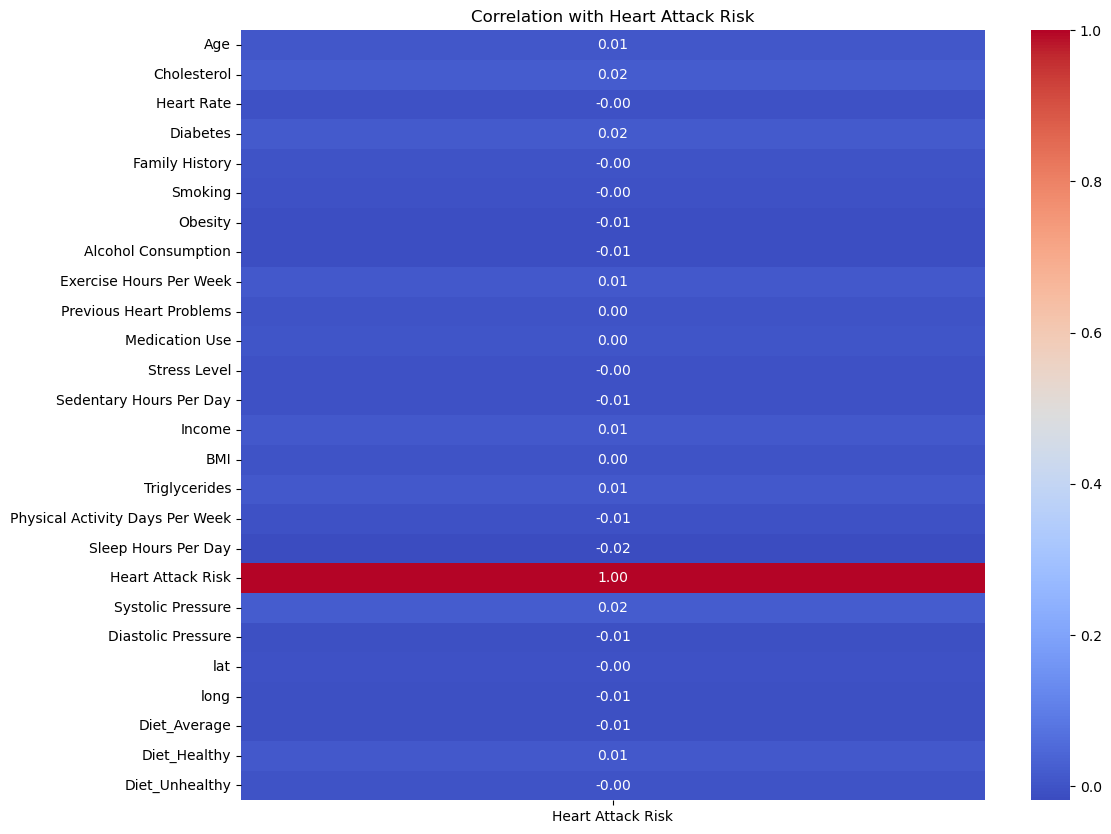

In [100]:
# Compute the correlation matrix
correlation_matrix = encoded_df.corr()

import seaborn as sns
import matplotlib.pyplot as plt

# Visualize it using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix[['Heart Attack Risk']], annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation with Heart Attack Risk")
plt.show()


In [101]:
# Save encoded_df as a JSON file with records orientation
encoded_df.to_csv("Resources/encoded_df.csv")

In [ ]:
encoded_df.to_csv('https://aws-project-4.s3.ca-central-1.amazonaws.com/encoded_df.csv')

In [102]:
# Save encoded_df as a JSON file with records orientation
encoded_df.to_json("https://aws-project-4.s3.ca-central-1.amazonaws.com/encoded_df.json")